##Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample


#Loading Data

In [42]:
data = pd.read_csv(r"healthcare-dataset-stroke-data.csv")

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [5]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


#This block fills missing values in the 'bmi' column by replacing them with the mean BMI of groups defined by the combination of 'age', 'gender', and 'ever_married'.

In [43]:
data['bmi'] = data['bmi'].fillna(data.groupby(['age', 'gender', 'ever_married'])['bmi'].transform('mean'))

#This block of code visualizes boxplots for the bmi, avg_glucose_level, and age columns from the dataset, which help identify the distribution, central tendency, and potential outliers for each of these numeric variables.

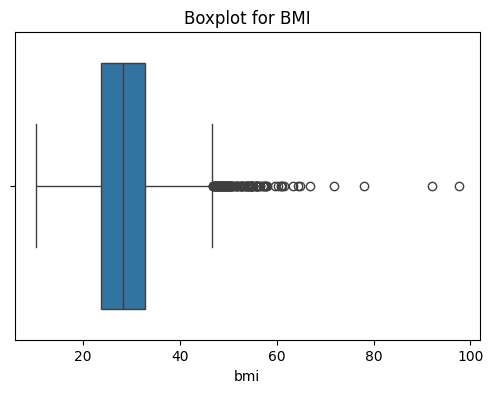

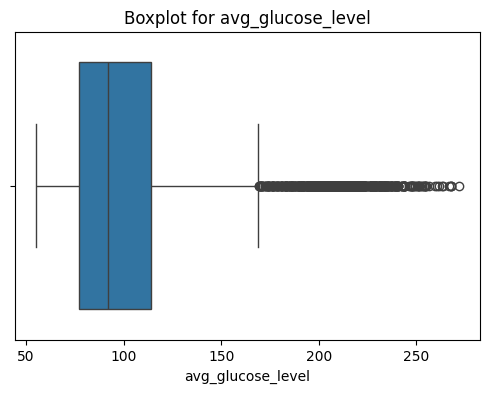

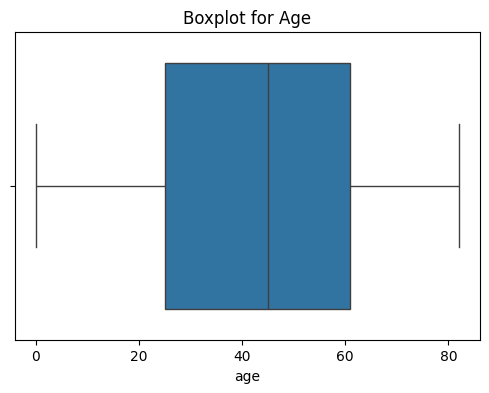

In [44]:
# Boxplot for BMI
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['bmi'])
plt.title("Boxplot for BMI")
plt.show()

# Boxplot for avg_glucose_level
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['avg_glucose_level'])
plt.title("Boxplot for avg_glucose_level")
plt.show()

# Boxplot for Age
plt.figure(figsize=(6, 4))
sns.boxplot(x=data['age'])
plt.title("Boxplot for Age")
plt.show()

##Data cleaning by removing outliers or extreme values in the 'bmi' and 'avg_glucose_level' columns to focus on a more reasonable range of values for analysis or model training.

In [45]:
data = data[data['bmi'] < 68]
data = data[data['avg_glucose_level']<260]

## Count the number of occurrences of each class in the 'stroke' column

In [46]:


stroke_class_counts = data['stroke'].value_counts()

# Display the counts for each class
print(stroke_class_counts)


stroke
0    4849
1     246
Name: count, dtype: int64


#convert categorical features (gender, ever_married, etc.) into numeric values, which is necessary for machine learning models that require numerical input. This is useful when working with datasets that contain string-based categorical data.

In [47]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns to be encoded
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Display the transformed dataset
print(data.head())


      id  gender   age  hypertension  heart_disease  ever_married  work_type  \
0   9046       1  67.0             0              1             1          2   
1  51676       0  61.0             0              0             1          3   
2  31112       1  80.0             0              1             1          2   
3  60182       0  49.0             0              0             1          2   
4   1665       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level        bmi  smoking_status  stroke  
0               1             228.69  36.600000               1       1  
1               0             202.21  29.689474               2       1  
2               0             105.92  32.500000               2       1  
3               1             171.23  34.400000               3       1  
4               0             174.12  24.000000               2       1  


# Scale the 'avg_glucose_level' and 'bmi' columns, transforming their values into a range of 0 to 1 using MinMax scaling. This is often used in machine learning to normalize data so that different features are on the same scale, preventing large values from dominating model training.

In [48]:
scaler = MinMaxScaler()
for col in ['avg_glucose_level','bmi']:
    scaler.fit(data[[col]])
    data[col]=scaler.transform(data[[col]])

#In imbalanced datasets, the model tends to favor the majority class. Upsampling helps the model learn better from the minority class by providing more examples, thus improving classification performance for the minority class (in this case, people who had a stroke).

In [49]:
from sklearn.utils import resample

# Separate majority and minority classes
majority_class = data[data['stroke'] == 0]
minority_class = data[data['stroke'] == 1]

# Upsample the minority class
minority_upsampled = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match majority class
                              random_state=42)

# Combine the upsampled minority class with the majority class
upsampled_data = pd.concat([majority_class, minority_upsampled])

# Check the class distribution
print(upsampled_data['stroke'].value_counts())


stroke
0    4849
1    4849
Name: count, dtype: int64


##convert categorical variables into numeric values using the LabelEncoder from sklearn.

In [50]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# List of categorical columns to be encoded
categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Apply LabelEncoder to each categorical column
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])

# Display the transformed dataset
print(data.head())


      id  gender   age  hypertension  heart_disease  ever_married  work_type  \
0   9046       1  67.0             0              1             1          2   
1  51676       0  61.0             0              0             1          3   
2  31112       1  80.0             0              1             1          2   
3  60182       0  49.0             0              0             1          2   
4   1665       0  79.0             1              0             1          3   

   Residence_type  avg_glucose_level       bmi  smoking_status  stroke  
0               1           0.848712  0.465487               1       1  
1               0           0.719231  0.343177               2       1  
2               0           0.248399  0.392920               2       1  
3               1           0.567747  0.426549               3       1  
4               0           0.581879  0.242478               2       1  


#This block of code uses train_test_split from sklearn to split the dataset into training and testing sets for a machine learning model.

In [51]:
from sklearn.model_selection import train_test_split

# Split the upsampled data into features (X) and target (y)
X = upsampled_data.drop(columns='stroke')  # Features
y = upsampled_data['stroke']  # Target

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (7758, 11)
Testing set size: (1940, 11)


#This block of code is used to handle missing values in the dataset by imputing (filling) them using the mean value of each column.

In [52]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean (you can change strategy to 'median' or 'most_frequent' if needed)
imputer = SimpleImputer(strategy='mean')

#Compute and visualize the correlation matrix of numerical data in the dataset using a heatmap.

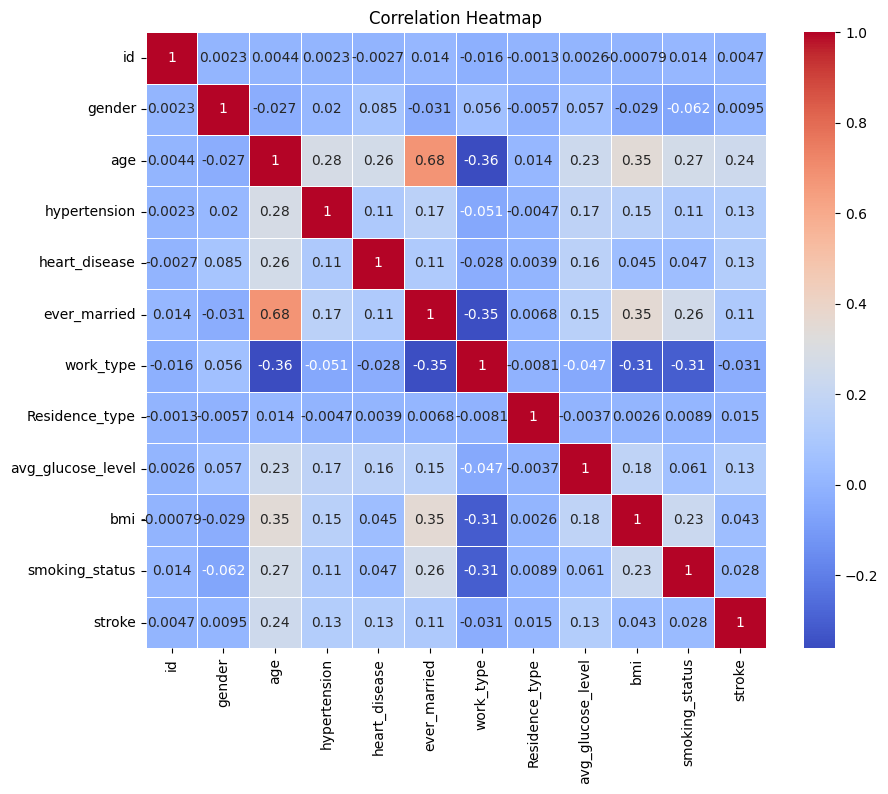

In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numeric columns or apply encoding if necessary
# For simplicity, we drop non-numeric columns here
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


#The Logistic Regression model is trained on the imputed training data (X_train_imputed, y_train).

In [54]:


# Train the Logistic Regression model with the imputed data
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test_imputed)

# Evaluate the Logistic Regression model
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       970
           1       0.76      0.83      0.79       970

    accuracy                           0.78      1940
   macro avg       0.78      0.78      0.78      1940
weighted avg       0.78      0.78      0.78      1940



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#train a Logistic Regression model with a specified maximum number of iterations.

In [55]:
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_imputed, y_train)


LogisticRegression(max_iter=1000, random_state=42)

#This block of code applies feature scaling to the training and testing data using StandardScaler, then trains and evaluates a Logistic Regression model on the scaled data.

In [56]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Train Logistic Regression with scaled data
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred = log_reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.80      0.74      0.76       970
           1       0.75      0.81      0.78       970

    accuracy                           0.77      1940
   macro avg       0.78      0.77      0.77      1940
weighted avg       0.78      0.77      0.77      1940



 #train and evaluates a Random Forest classifier using the training and testing datasets.

In [57]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred_rf = rf.predict(X_test_imputed)

# Evaluate Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       970
           1       0.98      1.00      0.99       970

    accuracy                           0.99      1940
   macro avg       0.99      0.99      0.99      1940
weighted avg       0.99      0.99      0.99      1940



#Train and evaluates an XGBoost classifier (eXtreme Gradient Boosting) using the training and test datasets.

In [35]:
from xgboost import XGBClassifier

# Train XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred_xgb = xgb.predict(X_test_imputed)

# Evaluate XGBoost
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97       970
           1       0.94      1.00      0.97       970

    accuracy                           0.97      1940
   macro avg       0.97      0.97      0.97      1940
weighted avg       0.97      0.97      0.97      1940



#Train and evaluates a Gradient Boosting classifier using the training and test datasets.

In [36]:
from sklearn.ensemble import GradientBoostingClassifier

# Train Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_imputed, y_train)

# Predict on the test set
y_pred_gb = gb.predict(X_test_imputed)

# Evaluate Gradient Boosting
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       970
           1       0.80      0.91      0.85       970

    accuracy                           0.84      1940
   macro avg       0.84      0.84      0.84      1940
weighted avg       0.84      0.84      0.84      1940

